<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab12_nlp-introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12 - Natural Language Processing - Introduction

### Author: Szymon Nowakowski


# Introduction
---------------
In this class, we take our first steps into Natural Language Processing (NLP). We'll begin by averaging word embeddings to form sentence-level representations—a simple but effective baseline. **Attention** generalizes this idea by learning which words matter more in context, assigning dynamic weights instead of treating each word equally. In this sense, **attention can be thought of as a learned, weighted average**.

This is our gateway into more advanced techniques. In the next class, we’ll study **self-attention**, the backbone of modern architectures like the Transformer. And if time permits, we may even explore the **full Transformer** model in our final class.

I would like to express my gratitude to my colleague Przemysław Olbratowski for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.


### Yelp Reviews Polarity Dataset  
--------------

This dataset contains **over 560k full-text reviews** from Yelp, labeled for **binary sentiment**:  
- **positive** (5-star reviews)  
- **negative** (1-star reviews)  

We will not use the full dataset, because it cannot be handled by Colab RAM. We will use short sequences with the word `however`. It is too restrictive, though, so we will allow word `but` as well.

Each example is a **real user-generated review**, typically 2–5 sentences long, capturing clear and direct sentiment in natural language.  
There are no ambiguous or neutral labels, making this dataset ideal for training and evaluating **binary sentiment classifiers**.

The dataset was curated and released as part of the **FastText** and **Text Classification Benchmarks** by researchers at Facebook AI. It is widely used for benchmarking sentiment models in both academia and industry.


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [2]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128
pattern = re.compile(r"\b(but|however)\b", flags=re.IGNORECASE)   # Looking for however ONLY is too restrictive (too small a dataset)

# Load dataset
raw = load_dataset("yelp_polarity")

# Define fast batch filter function
def batch_filter(batch):
    return [
        bool(pattern.search(text)) and len(text.split()) <= MAX_LEN
        for text in batch["text"]
    ]

# Filter with batching
train_raw = raw["train"].filter(batch_filter, batched=True, batch_size=10_000)
test_raw  = raw["test"].filter(batch_filter, batched=True, batch_size=10_000)

# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/560000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/38000 [00:00<?, ? examples/s]


Train distribution:
  0: 69385 (50.55%)
  1: 67884 (49.45%)

Validation distribution:
  0: 2412 (51.41%)
  1: 2280 (48.59%)

Test distribution:
  0: 2370 (50.50%)
  1: 2323 (49.50%)


## Some examples

In [3]:
label_map = {0: "negative", 1: "positive"}

for i in range(10):
    print(f"[{label_map[train_labels[i]]}] {train_texts[i]}\n")

[positive] All the food is great here. But the best thing they have is their wings. Their wings are simply fantastic!!  The \""Wet Cajun\"" are by the best & most popular.  I also like the seasoned salt wings.  Wing Night is Monday & Wednesday night, $0.75 whole wings!\n\nThe dining area is nice. Very family friendly! The bar is very nice is well.  This place is truly a Yinzer's dream!!  \""Pittsburgh Dad\"" would love this place n'at!!

[negative] Wing sauce is like water. Pretty much a lot of butter and some hot sauce (franks red hot maybe).  The whole wings are good size and crispy, but for $1 a wing the sauce could be better. The hot and extra hot are about the same flavor/heat.  The fish sandwich is good and is a large portion, sides are decent.

[negative] This place is absolute garbage...  Half of the tees are not available, including all the grass tees.  It is cash only, and they sell the last bucket at 8, despite having lights.  And if you finish even a minute after 8, don't p

# Tokenizer
-------------------

To feed text into a neural network, we need to represent words in a "neural-network-ish" way — that is, as numbers. The standard approach is to use a tokenizer, often from a pretrained model. However, since we plan to experiment with our own attention modules later on, **we’ll avoid using any pretrained tokenizer**.

Instead, we’ll go with a simple, word-based tokenization. As part of this, we’ll clean the text by removing any non-standard HTML tags, digits, extra whitespace, and punctuation. We’ll also convert all words to lowercase to ensure consistency.

## Special Tokens: `<PAD>` and `<UNK>`

In our text preprocessing pipeline, we convert each word to a number using a vocabulary. Two special tokens help us handle padding and unknown words.




### `<PAD>` — Padding Token

- Represents empty slots when we need all input sequences to be the same length.
- Assigned index `0`.
- Used so that batches of sentences can be processed together by the model.

*For example:*

Original: `[17, 5, 23]`  
Padded:   `[17, 5, 23, 0, 0]` (for a fixed length of 5)




### `<UNK>` — Unknown Token

- Represents any word that is **not in the vocabulary**.
- Assigned index `1`.
- Occurs when:
  1. A word was **too rare in the training data** (appeared only once and was excluded from the vocabulary).
  2. A word appears **only in validation or test data**.

> In our setup, we **excluded all words that appear only once** in the training set.  
> So even in the training data, some tokens are replaced with `<UNK>`.  
> These are called **rare unknowns** — they help the model learn how to handle unusual or unfamiliar words.


By including `<UNK>` during training, we teach the model how to deal with unseen or rare words at test time — which is **crucial for generalization**.


In [4]:


def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break





Original:   Waterfront Geagle is my primary market. Now that they've expanded and reorganized, I rarely even have to set foot in Target anymore. Yippie! There's a wine kiosk (suck it PA liquor laws), you can buy crazy expensive 6 packs, cheese market, bakery, salad and hot bar, butcher, florist, dry cleaners, international foods, pharmacy, and a little cosmetics/beauty/bath area. They usually have a sufficient number of lanes open, and it doesn't get nearly as crowded as Market District. I do wish a bulk spice selection was included as part of the expansion, but you can't always get what you want, I suppose.
Tokenized:  ['waterfront', 'geagle', 'is', 'my', 'primary', 'market', 'now', 'that', 'they', 've', 'expanded', 'and', 'reorganized', 'i', 'rarely', 'even', 'have', 'to', 'set', 'foot', 'in', 'target', 'anymore', 'yippie', 'there', 's', 'a', 'wine', 'kiosk', 'suck', 'it', 'pa', 'liquor', 'laws', 'you', 'can', 'buy', 'crazy', 'expensive', 'packs', 'cheese', 'market', 'bakery', 'salad

## Notice!

Notice that the `<UNK>` token (coded as 1) is visible in the rows above. Also, there is an abundance of `<PAD>` tokens (coded as 0).

# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [5]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Training Loop as We Already Got to Know It Well
----------------

## Train Loop Function

In [6]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cpu


## Plot Function

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Simple 1 Feature Aproach
------------------

Before we proceed with a multi-feature network, let's try to go simpler, for a moment. Let's consider a single feature.

Working on cpu
Epoch 000 | Train Loss: 0.9325, Acc: 0.4945 | Val Loss: 0.8956, Acc: 0.4859
Epoch 010 | Train Loss: 0.6925, Acc: 0.5260 | Val Loss: 0.6910, Acc: 0.5328
Epoch 020 | Train Loss: 0.6608, Acc: 0.6075 | Val Loss: 0.6540, Acc: 0.6215
Epoch 030 | Train Loss: 0.4978, Acc: 0.8507 | Val Loss: 0.4914, Acc: 0.8529
Epoch 040 | Train Loss: 0.3860, Acc: 0.8717 | Val Loss: 0.3840, Acc: 0.8747
Epoch 050 | Train Loss: 0.3229, Acc: 0.8862 | Val Loss: 0.3223, Acc: 0.8898
Epoch 060 | Train Loss: 0.2822, Acc: 0.8975 | Val Loss: 0.2823, Acc: 0.8992
Epoch 070 | Train Loss: 0.2541, Acc: 0.9051 | Val Loss: 0.2554, Acc: 0.9035
Epoch 080 | Train Loss: 0.2339, Acc: 0.9114 | Val Loss: 0.2372, Acc: 0.9066
Epoch 090 | Train Loss: 0.2191, Acc: 0.9159 | Val Loss: 0.2247, Acc: 0.9120
Elapsed time: 422.93 seconds


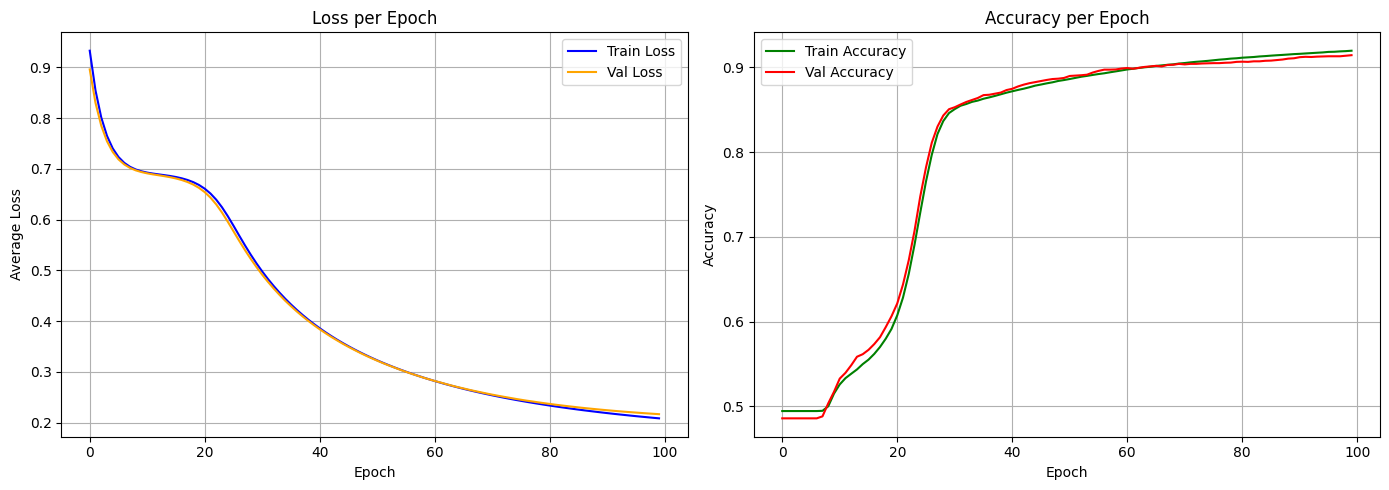

In [8]:
feature_cnt = 1
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_1 = Net_1()

# Execute training
train_loss, val_loss, train_acc, val_acc = train_model(net_1, train_loader, val_loader, epochs = 140)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Sentiment Polarity

Since our embeddings have only 1 feature (`feature_cnt = 1`), each word is embedded to a scalar. We can interpret this scalar as a kind of sentiment polarity, especially since our model is trained for sentiment classification.

In [9]:
import numpy as np

# Get the embedding weights as a NumPy array
embedding_weights = net_1.embedding.weight.detach().cpu().numpy().squeeze()  # shape: (vocab_len,)

# Reverse vocab dictionary to map indices back to words
id2token = {idx: token for token, idx in vocab.items()}

# Skip <PAD> and <UNK> tokens (indices 0 and 1)
valid_indices = np.array([idx for idx in range(2, len(embedding_weights)) if idx in id2token])
valid_embeddings = embedding_weights[valid_indices]

# Sort and select indices
sorted_pos = np.argsort(-valid_embeddings)
sorted_neg = np.argsort(valid_embeddings)
sorted_neutral = np.argsort(np.abs(valid_embeddings))

top_pos_indices = valid_indices[sorted_pos[:20]]
top_neg_indices = valid_indices[sorted_neg[:20]]
top_neutral_indices = valid_indices[sorted_neutral[:20]]

# Print words and corresponding embedding values
def print_words_with_embeddings(indices, title):
    print(f"\n{title}")
    for idx in indices:
        word = id2token[int(idx)]
        value = embedding_weights[int(idx)]
        print(f"{word:15} -> {value:.4f}")

print_words_with_embeddings(top_pos_indices, "Top 20 most positive words:")
print_words_with_embeddings(top_neg_indices, "Top 20 most negative words:")
print_words_with_embeddings(top_neutral_indices, "Top 20 most neutral words:")



Top 20 most positive words:
delicious       -> 14.3182
awesome         -> 13.4415
perfect         -> 12.8404
excellent       -> 12.8282
loved           -> 12.7890
fantastic       -> 12.1197
incredible      -> 12.1162
outstanding     -> 11.3768
amazing         -> 11.3286
yummy           -> 11.3268
great           -> 11.1888
perfection      -> 11.1664
wonderful       -> 11.0631
definitely      -> 10.9425
best            -> 10.8989
pleasantly      -> 10.8869
heaven          -> 10.7021
favorite        -> 10.4935
complaint       -> 10.3910
delish          -> 10.3510

Top 20 most negative words:
terrible        -> -13.7760
bland           -> -13.3265
meh             -> -13.1632
mediocre        -> -12.7693
poorly          -> -12.6525
worst           -> -12.3707
poor            -> -11.7599
awful           -> -11.7237
disappointed    -> -11.5895
overpriced      -> -11.5692
elsewhere       -> -11.2176
disappointing   -> -11.1397
gross           -> -10.9912
horrible        -> -10.9779
ok        

## Classificator

It is interesting to see how the polar sentiment gets translated into the two  class values. Let's see:

In [10]:
# Extract weights and bias from the classifier layer
classifier_weight = net_1.classifier.weight.detach().cpu().numpy()
classifier_bias = net_1.classifier.bias.detach().cpu().numpy()

print("Classifier weights (shape: {}):".format(classifier_weight.shape))
print(classifier_weight)

print("\nClassifier bias (shape: {}):".format(classifier_bias.shape))
print(classifier_bias)

print("Recall our coding: ")
print(label_map)


Classifier weights (shape: (1, 1)):
[[9.2162695]]

Classifier bias (shape: (1,)):
[-0.06823753]
Recall our coding: 
{0: 'negative', 1: 'positive'}


In [11]:
# Hand-picked test sentences
texts = [
    "I love this!",
    "This is terrible",
    "Thank you so much!",
    "I hate this",
    "Wow, awesome!",
    "This sucks"
]

# Convert texts to input_ids using your tokenizer
input_ids = process_texts(texts, vocab)
input_tensor = torch.tensor(input_ids).to(next(net_1.parameters()).device)

# Predict with trained model
net_1.eval()
with torch.no_grad():
    logits = net_1(input_tensor).squeeze()
    probs = torch.sigmoid(logits)

# Print results
for text, prob in zip(texts, probs):
    print(f"{text:30} -> predicted probability of POSITIVE: {prob.item():.4f}")


I love this!                   -> predicted probability of POSITIVE: 0.6619
This is terrible               -> predicted probability of POSITIVE: 0.2504
Thank you so much!             -> predicted probability of POSITIVE: 0.6419
I hate this                    -> predicted probability of POSITIVE: 0.3830
Wow, awesome!                  -> predicted probability of POSITIVE: 0.7674
This sucks                     -> predicted probability of POSITIVE: 0.3146


# Adding Artificial (Flipped) Sentences
-----------------

It will make the dataset diffinitely more demanding and also more suited for attention that we intend to add later.

The idea is to add artificial sentences, that are mixes of the *before however* part of one sentence and *after however* part of another sentence. The label is always matching the second sentence (that, from which we take the second part).

Like, in **the service is terrible however the food very tasty** (*positive*) mixed with **I like it, however my girlfriend did not** (*negative*) results in **the service is terrible, however my girlfriend did not** (*negative*). It is artificial, however it carries the idea that the second part is more important.

Also, we will intentionally try to make the label distribution more equal, sampling sentences from both classes with reversed proportion.

In [12]:
import random

def collect_splits(texts, labels):
    lefts, rights, y = [], [], []
    for text, label in zip(texts, labels):
        tokens = tokenize(text)
        if "however" in tokens:
            i = tokens.index("however")
            if 1 <= i < len(tokens) - 1:
                lefts.append(" ".join(tokens[:i]))
                rights.append(" ".join(tokens[i + 1:]))
                y.append(label)
    return lefts, rights, y

def mix_flipped_opposite_balanced(lefts, rights, labels, generate_cnt, max_len=128, seed=42):
    import random
    random.seed(seed)

    # Group rights by label
    rights_by_label = {0: [], 1: []}
    for r, y in zip(rights, labels):
        rights_by_label[y].append(r)

    # Count per class
    n_0 = len(rights_by_label[0])
    n_1 = len(rights_by_label[1])

    # Determine reversed proportions
    total = n_0 + n_1
    p_0 = n_1 / total  # want to boost class 1 (minority), so sample more from 0
    p_1 = n_0 / total  # want to boost class 0 (minority), so sample more from 1

    # Target number of augmented samples per class (reversed proportion)

    n_gen_0 = int(p_0 * generate_cnt)
    n_gen_1 = int(p_1 * generate_cnt)

    flipped_texts = []
    flipped_labels = []

    for label, count in [(0, n_gen_0), (1, n_gen_1)]:
        rights_pool = rights_by_label[label]
        for right in random.choices(rights_pool, k=count):
            left = random.choice(lefts)
            mixed = f"{left} however {right}"
            if len(mixed.split()) <= max_len:
                flipped_texts.append(mixed)
                flipped_labels.append(label)

    return flipped_texts, flipped_labels



def augment_with_flips(texts, labels, generate_cnt, max_len=128, seed=42):
    lefts, rights, y = collect_splits(texts, labels)
    flipped_texts, flipped_labels = mix_flipped_opposite_balanced(lefts, rights, y, generate_cnt, max_len=max_len, seed=seed)

    texts_extended = texts + flipped_texts
    labels_extended = labels + flipped_labels

    print(f"Added {len(flipped_texts)} flipped samples.")
    print_distribution("Augmented", labels_extended)

    return texts_extended, labels_extended

train_texts, train_labels = augment_with_flips(train_texts, train_labels, len(train_texts)/4, max_len=MAX_LEN, seed=42)
val_texts, val_labels     = augment_with_flips(val_texts,   val_labels, len(val_texts)/4, max_len=MAX_LEN, seed=43)
test_texts, test_labels   = augment_with_flips(test_texts,  test_labels, len(test_texts)/4, max_len=MAX_LEN, seed=44)

# Reprocess splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Recalculate data loaders
train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


Added 8033 flipped samples.

Augmented distribution:
  0: 74171 (51.05%)
  1: 71131 (48.95%)
Added 274 flipped samples.

Augmented distribution:
  0: 2581 (51.97%)
  1: 2385 (48.03%)
Added 287 flipped samples.

Augmented distribution:
  0: 2541 (51.02%)
  1: 2439 (48.98%)


# More Features, Now
---------------

Working on cpu
Epoch 000 | Train Loss: 0.6882, Acc: 0.5759 | Val Loss: 0.6787, Acc: 0.6671
Epoch 010 | Train Loss: 0.3195, Acc: 0.8816 | Val Loss: 0.3139, Acc: 0.8874
Epoch 020 | Train Loss: 0.2381, Acc: 0.9095 | Val Loss: 0.2485, Acc: 0.9072
Epoch 030 | Train Loss: 0.2090, Acc: 0.9201 | Val Loss: 0.2349, Acc: 0.9122
Epoch 040 | Train Loss: 0.1927, Acc: 0.9270 | Val Loss: 0.2338, Acc: 0.9130
Epoch 050 | Train Loss: 0.1812, Acc: 0.9316 | Val Loss: 0.2367, Acc: 0.9116
Epoch 060 | Train Loss: 0.1720, Acc: 0.9359 | Val Loss: 0.2416, Acc: 0.9102
Epoch 070 | Train Loss: 0.1641, Acc: 0.9391 | Val Loss: 0.2473, Acc: 0.9100
Epoch 080 | Train Loss: 0.1571, Acc: 0.9423 | Val Loss: 0.2542, Acc: 0.9088
Epoch 090 | Train Loss: 0.1508, Acc: 0.9452 | Val Loss: 0.2612, Acc: 0.9078
Elapsed time: 671.01 seconds


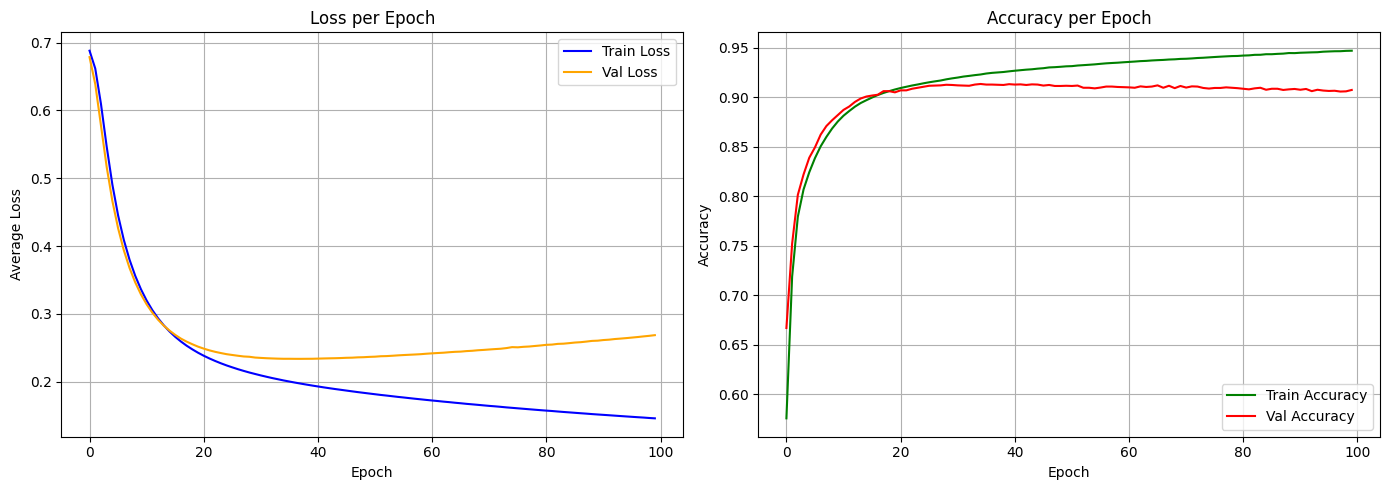

In [13]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_f=Net_F()
train_loss, val_loss, train_acc, val_acc = train_model(net_f, train_loader, val_loader, epochs=100)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Towards Attention!
---------------------------


## The Entry Point

The entry point is our model with averaged multiple features:

In [14]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #SIZE: batch, words
        features = self.embedding(index)             #SIZE: batch, words, features

        ### This is where AVERAGING takes place
        features = features.mean(-2)                 #SIZE: batch, features


        classifications = self.classifier(features)  #SIZE: batch, 1
        logits = classifications.squeeze(-1)         #SIZE: batch
        return logits

## Less Explicit Averaging

The code below is equivalent to taking the `mean()` over words:

In [15]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        weights = torch.ones((batch, 1, words)) / words   # create EQUAL WEIGHT tensor summing to 1.0 ( words x (1/words) )
                                                         #SIZE: batch, 1, words
        features = weights @ features                    #SIZE: batch, 1, features


        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

And now let us refactor this, taking the weighted average part into a separate `Attention` module:

In [16]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features):                         #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        weights = torch.ones((batch, 1, words)) / words   # create EQUAL WEIGHT tensor summing to 1.0 ( words x (1/words) )
                                                         #SIZE: batch, 1, words
        features = weights @ features                    #SIZE: batch, 1, features
        return features

class Net_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

All that we did up until that point was to rewrite taking the `mean()` into a separate `Attention` which calculates the weighted averager with equal weights over weights.

## Introducing the Notion of Energy

Another useful concept is that of the energy. The energy equal to 0 uniformly for all words translates (with the use of `softmax`) into the equal weights, so the below version is still equivalent to what we already had (but, arguably, it looks much more complex):

In [17]:
import torch.nn.functional as F

feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = torch.zeros((batch, 1, words))       #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

## Something New - Learned Energies

Working on cpu
Epoch 000 | Train Loss: 0.6895, Acc: 0.5562 | Val Loss: 0.6763, Acc: 0.6393
Epoch 010 | Train Loss: 0.2474, Acc: 0.8985 | Val Loss: 0.2588, Acc: 0.8921
Epoch 020 | Train Loss: 0.2053, Acc: 0.9166 | Val Loss: 0.2469, Acc: 0.9001
Epoch 030 | Train Loss: 0.1765, Acc: 0.9301 | Val Loss: 0.2594, Acc: 0.8957
Epoch 040 | Train Loss: 0.1539, Acc: 0.9406 | Val Loss: 0.2884, Acc: 0.8959
Elapsed time: 404.66 seconds


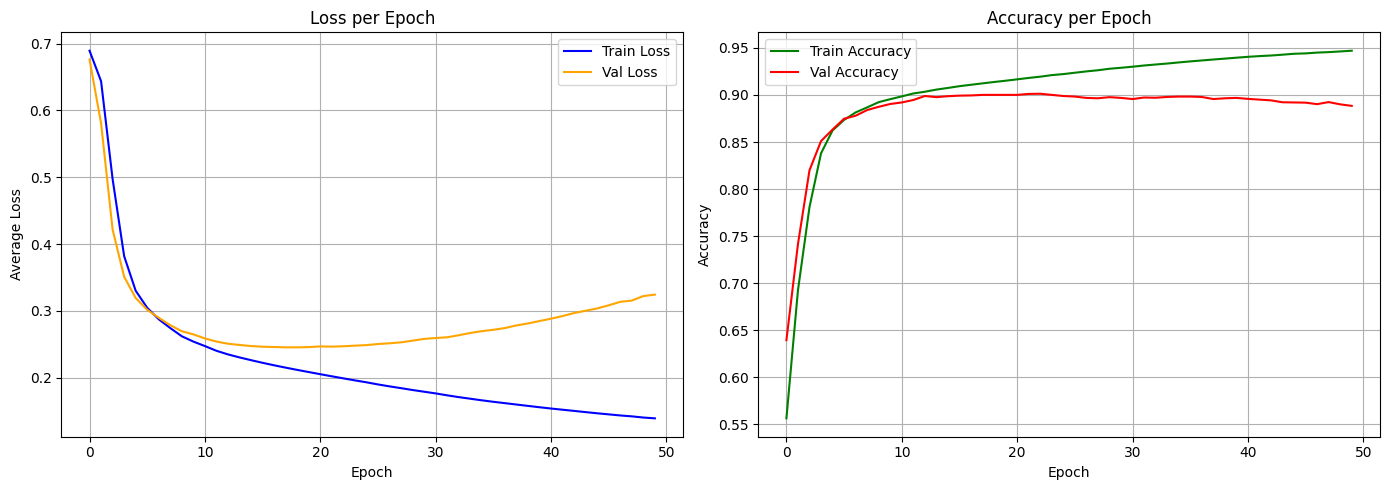

In [18]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att = Net_Attention()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att, train_loader, val_loader, epochs = 50)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Positional Encoding
-----------------------

In [19]:
pos_cnt = 4

def sinusoid_positions(max_len = MAX_LEN, dim = pos_cnt):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i   = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (10000 ** (2 * (i//2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S          #  SIZE: words, features  (constant matrix throuoght all computations)



 - Even dimensions (0, 2, 4, ...) use sine.

 - Odd dimensions (1, 3, 5, ...) use cosine.

This gives a unique pattern per position that's also smooth and distance-preserving.

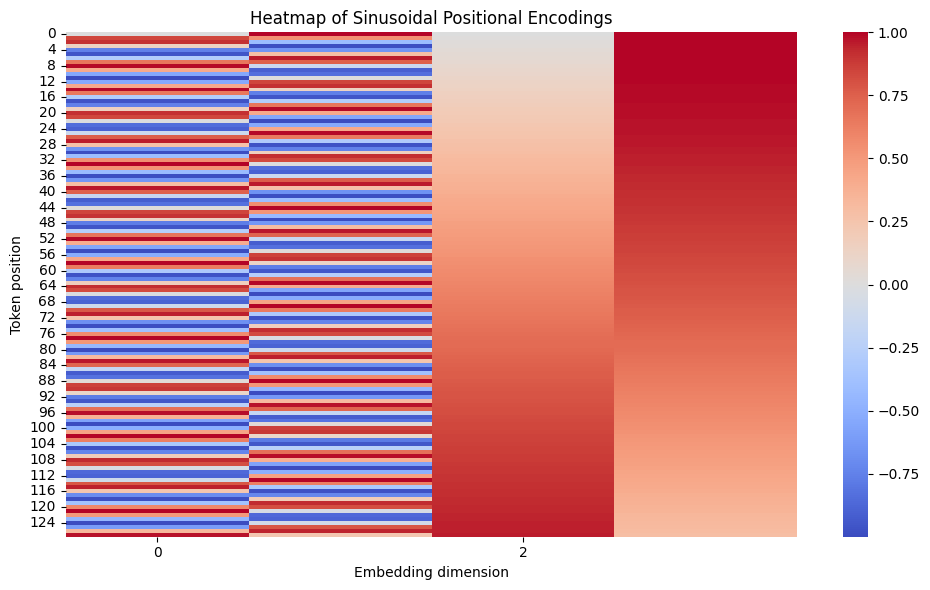

In [20]:


import matplotlib.pyplot as plt
import seaborn as sns

# Create sinusoidal matrix S
S = sinusoid_positions()

# Plot as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(S, cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Heatmap of Sinusoidal Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()



In [ ]:
embed_cnt = 16          # word embeddings
pos_cnt = 4             # pos embeddings
feature_cnt = feature_cnt + pos_cnt

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_And_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        batch = index.size(0)
        pos_enc = S.unsqueeze(0)                         #SIZE: 1, words, pos_cnt
        pos_enc = pos_enc. expand(batch, -1, -1)         #SIZE: batch, words, pos_cnt
        features = torch.cat([self.embedding(index), pos_enc], dim = -1)
                                                         #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att_pe = Net_Attention_And_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att_pe, train_loader, val_loader, epochs = 100)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

Working on cpu
Epoch 000 | Train Loss: 0.6868, Acc: 0.5671 | Val Loss: 0.6696, Acc: 0.6611
Epoch 010 | Train Loss: 0.2438, Acc: 0.9001 | Val Loss: 0.2565, Acc: 0.8955
Epoch 020 | Train Loss: 0.1999, Acc: 0.9195 | Val Loss: 0.2465, Acc: 0.9011
Epoch 030 | Train Loss: 0.1715, Acc: 0.9327 | Val Loss: 0.2624, Acc: 0.9011
Epoch 040 | Train Loss: 0.1514, Acc: 0.9415 | Val Loss: 0.2987, Acc: 0.8937
Epoch 050 | Train Loss: 0.1346, Acc: 0.9494 | Val Loss: 0.3431, Acc: 0.8888
Epoch 060 | Train Loss: 0.1238, Acc: 0.9538 | Val Loss: 0.3912, Acc: 0.8826


In [ ]:
embed_cnt = 16        # word embeddings
pos_cnt = 4             # pos embeddings
feature_cnt = embed_cnt + pos_cnt

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #SIZE: batch, words
        batch = index.size(0)
        pos_enc = S.unsqueeze(0)                     #SIZE: 1, words, pos_cnt
        pos_enc = pos_enc. expand(batch, -1, -1)     #SIZE: batch, words, pos_cnt
        features = torch.cat([self.embedding(index), pos_enc], dim = -1)
                                                     #SIZE: batch, words, features


        ### This is where AVERAGING takes place
        features = features.mean(-2)                 #SIZE: batch, features


        classifications = self.classifier(features)  #SIZE: batch, 1
        logits = classifications.squeeze(-1)         #SIZE: batch
        return logits

net_pe = Net_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_pe, train_loader, val_loader, epochs = 100)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)